# TP: State space representation and forecasting of joint angles

In this Jupyter notebook, we will see the modeling of human motions using state-space through an autoregressive model (SARIMAX), where endogenous and exogenous variables are used to forecast local joint angle trajectories.

First, you will learn how to model motions performed by a subject and craftsman, then use the trained model to:
* Analyze contribution of joint angles for the trajectory prediction of other joint angles
* Statically and dynamically forecast the other motion iterations of the same class

**General instructions:**
The following notebook illustrates how to model and forecast two different human movements from a  dataset in recorded with the full-body Nansense system.

The script is divided into five sections:

**1.** Load the training BVH file of each movement provided inside the folder BVH

**2.** Train an autoregressive model using SARIMAX per movement

**3.** Analyze coefficients and p-values resulted from the generated models

**4.** Static forecasting

**5.** Dynamic forecasting

Please read and follow the instructions placed before specific cells and modify the lines of code requested. 

* Movements to analyze are the following, along with a figure showing the joint rotations measured:

<table><tr>
<td> 
  <p align="center" style="padding: 10px">
    <img alt="Forwarding" src="Images/Bending.png" width="320" height = "320">
    <br>
    <em style="color: grey">Bending forward more than 60°.</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="Images/Glassblowing.png" width="265">
    <br>
    <em style="color: grey">Shaping mealted glass with the blowpipe.</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="Images/sensors.PNG" width="375">
    <br>
    <em style="color: grey">Rotations measured and their axis orientation.</em>
  </p> 
</td>
</tr></table>

##  1. Load BVH files to extract local joint angles

In [1]:
# Load required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pymo.parsers import BVHParser
from pymo.viz_tools import *
from pymo.preprocessing import *
from sklearn.pipeline import Pipeline

from sklearn import preprocessing

import statsmodels.api as sm
import math

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

**1.1** Indicate the path to access the training and test motions (modify path if needed):

In [2]:
pathsB1='BVH/Bending/Train_Bending.bvh'
pathsB2='BVH/Bending/Test_Bending.bvh'

pathsG1='BVH/Glassblowing/Train_Glassblowing.bvh'
pathsG2='BVH/Glassblowing/Test_Glassblowing.bvh'

**1.2** Parser the BVH files with `parser.parse(*path*)`, then print the joints hierarchy with `print_skel(*parsed_data*)`:

In [3]:
parser = BVHParser()
parsed_dataB1 = parser.parse(pathsB1)
parsed_dataB2 = parser.parse(pathsB2)
parsed_dataG1 = parser.parse(pathsG1)
parsed_dataG2 = parser.parse(pathsG2)

print_skel(parsed_dataB1)

- Hips (None)
| | - RightUpLeg (Hips)
| | - RightLeg (RightUpLeg)
| | - RightFoot (RightLeg)
| | - RightToeBase (RightFoot)
| | - RightFootToe (RightToeBase)
| | - RightFootToe_Nub (RightFootToe)
| - LeftUpLeg (Hips)
| - LeftLeg (LeftUpLeg)
| - LeftFoot (LeftLeg)
| - LeftToeBase (LeftFoot)
| - LeftFootToe (LeftToeBase)
| - LeftFootToe_Nub (LeftFootToe)
- Spine (Hips)
- Spine1 (Spine)
- Spine2 (Spine1)
- Spine3 (Spine2)
| | - RightShoulder (Spine3)
| | - RightShoulder2 (RightShoulder)
| | - RightArm (RightShoulder2)
| | - RightForeArm (RightArm)
| | - RightHand (RightForeArm)
| | | | | | - RightHandPinky (RightHand)
| | | | | | - RightHandPinky1 (RightHandPinky)
| | | | | | - RightHandPinky2 (RightHandPinky1)
| | | | | | - RightHandPinky3 (RightHandPinky2)
| | | | | | - RightHandPinky3_Nub (RightHandPinky3)
| | | | | - RightHandRing (RightHand)
| | | | | - RightHandRing1 (RightHandRing)
| | | | | - RightHandRing2 (RightHandRing1)
| | | | | - RightHandRing3 (RightHandRing2)
| | | | | - R

**1.3** Create a dataframe from pandas with the motion data using `parsed_data.values`:

In [4]:
mocap_dataB1 = parsed_dataB1.values.reset_index().iloc[:,1:]
mocap_dataB2 = parsed_dataB2.values.reset_index().iloc[:,1:]

mocap_dataG1 = parsed_dataG1.values.reset_index().iloc[:,1:]
mocap_dataG2 = parsed_dataG2.values.reset_index().iloc[:,1:]

mocap_dataB1.head()

,Hips_Xposition,Hips_Yposition,Hips_Zposition,Hips_Zrotation,Hips_Xrotation,Hips_Yrotation,Spine_Xposition,Spine_Yposition,Spine_Zposition,Spine_Zrotation,...,RightToeBase_Zposition,RightToeBase_Zrotation,RightToeBase_Xrotation,RightToeBase_Yrotation,RightFootToe_Xposition,RightFootToe_Yposition,RightFootToe_Zposition,RightFootToe_Zrotation,RightFootToe_Xrotation,RightFootToe_Yrotation
0,-18.7419,93.8702,9.38722,0.061379,-0.070951,127.856,2.664540e-15,8.59463,0.000000e+00,0.960383,...,12.5,3.639860e-20,6.066430e-21,-0.000000e+00,-8.881780e-16,0.000000e+00,4.0,-2.77975,-0.630467,-26.8291
1,-18.7403,93.8701,9.38595,0.061364,-0.070956,127.853,8.881780e-16,8.59463,0.000000e+00,0.958660,...,12.5,7.765030e-19,-7.765030e-19,9.541660e-15,0.000000e+00,0.000000e+00,4.0,-2.77953,-0.626050,-26.8288
2,-18.7389,93.8701,9.38535,0.061347,-0.070995,127.849,0.000000e+00,8.59463,0.000000e+00,0.956242,...,12.5,0.000000e+00,0.000000e+00,-3.180550e-15,0.000000e+00,2.168400e-19,4.0,-2.77960,-0.625985,-26.8288
3,-18.7374,93.8701,9.38476,0.061336,-0.071037,127.846,-1.776360e-15,8.59463,-3.552710e-15,0.953427,...,12.5,-0.000000e+00,0.000000e+00,9.541660e-15,8.881780e-16,2.168400e-19,4.0,-2.77966,-0.625923,-26.8287
4,-18.7362,93.8701,9.38418,0.061330,-0.071084,127.844,8.881780e-16,8.59463,0.000000e+00,0.950158,...,12.5,-1.941260e-19,-3.882510e-19,-0.000000e+00,0.000000e+00,0.000000e+00,4.0,-2.77973,-0.625866,-26.8287


**1.4** Get rotations (local Euler angles) from the dataframe:

In [6]:
rot_cols = [col for col in mocap_dataB1.columns if 'rotation' in col]

eulerAnglesB1 = mocap_dataB1[rot_cols]
eulerAnglesB2 = mocap_dataB2[rot_cols]

eulerAnglesG1 = mocap_dataG1[rot_cols]
eulerAnglesG2 = mocap_dataG2[rot_cols]

eulerAnglesB1.head()

,Hips_Zrotation,Hips_Xrotation,Hips_Yrotation,Spine_Zrotation,Spine_Xrotation,Spine_Yrotation,Spine1_Zrotation,Spine1_Xrotation,Spine1_Yrotation,Spine2_Zrotation,...,RightLeg_Yrotation,RightFoot_Zrotation,RightFoot_Xrotation,RightFoot_Yrotation,RightToeBase_Zrotation,RightToeBase_Xrotation,RightToeBase_Yrotation,RightFootToe_Zrotation,RightFootToe_Xrotation,RightFootToe_Yrotation
0,0.061379,-0.070951,127.856,0.960383,-0.917328,-8.46844,-0.473765,0.418513,-0.638742,-0.237468,...,-0.589655,2.25810,-0.508125,-3.58967,3.639860e-20,6.066430e-21,-0.000000e+00,-2.77975,-0.630467,-26.8291
1,0.061364,-0.070956,127.853,0.958660,-0.919249,-8.46872,-0.473703,0.419483,-0.637612,-0.237437,...,-0.589972,2.25758,-0.514758,-3.58995,7.765030e-19,-7.765030e-19,9.541660e-15,-2.77953,-0.626050,-26.8288
2,0.061347,-0.070995,127.849,0.956242,-0.919775,-8.46818,-0.473628,0.419862,-0.637055,-0.237432,...,-0.590141,2.25744,-0.515717,-3.58992,0.000000e+00,0.000000e+00,-3.180550e-15,-2.77960,-0.625985,-26.8288
3,0.061336,-0.071037,127.846,0.953427,-0.919882,-8.46722,-0.473548,0.420118,-0.636545,-0.237421,...,-0.590358,2.25732,-0.516484,-3.58950,-0.000000e+00,0.000000e+00,9.541660e-15,-2.77966,-0.625923,-26.8287
4,0.061330,-0.071084,127.844,0.950158,-0.919634,-8.46589,-0.473470,0.420264,-0.636080,-0.237406,...,-0.590622,2.25720,-0.517156,-3.58910,-1.941260e-19,-3.882510e-19,-0.000000e+00,-2.77973,-0.625866,-26.8287


**1.5** Visualize the MoCap data in a plot to vaidate the quality of the recording:

In [7]:
# Create the object for transforming local joint angles to positions in order to plot the MoCap

mp = MocapParameterizer('position') 

In [8]:
# Plot the joint positions for the Bending motion

# Open in a figure:
%matplotlib qt  

positions = mp.fit_transform([parsed_dataB1]) # Get joint positions from the parsed data

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlim(-100,100)
ax.set_ylim(-100,200)
ax.set_zlim(-100,300)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_ylabel('Z')
for i in range(0,len(mocap_dataB2),30): # Run for loop to visualize the motion
    plt.gca().cla()
    ax.set_xlim(-100,100)
    ax.set_ylim(-100,200)
    ax.set_zlim(-100,300)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylabel('Z')
    draw_stickfigure3d(positions[0], frame=i, ax=ax)
    
    fig.canvas.draw()
    plt.pause(0.001)

C:\Users\aimove\Desktop\TP_SS_10JAN_solved\TP_SS_10JAN_solved\pymo\preprocessing.py:146: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Yposition'%joint] = pd.Series(data=[e[1] for e in tree_data[joint][1]], index=pos_df.index)
C:\Users\aimove\Desktop\TP_SS_10JAN_solved\TP_SS_10JAN_solved\pymo\preprocessing.py:147: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  pos_df['%s_Zposition'%joint] = pd.Series(data=[e[2] for e in tree_data[joint][1]], index=pos_df.index)
C:\Users\aimove\Desktop\TP_SS_10JAN_solved\TP_SS_10JAN_s

In [9]:
# Plot the joint positions for the Glassblowing motion

%matplotlib qt

positions = mp.fit_transform([parsed_dataG1])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlim(-500,-100)
ax.set_ylim(500,1000)
ax.set_zlim(-100,300)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_ylabel('Z')
for i in range(0,len(mocap_dataG1),20):
    plt.gca().cla()
    ax.set_xlim(-500,-100)
    ax.set_ylim(500,1000)
    ax.set_zlim(-100,300)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylabel('Z')
    draw_stickfigure3d(positions[0], frame=i, ax=ax)
    
    fig.canvas.draw()
    plt.pause(0.001)

## 2. Train an autoregressive model using SARIMAX 

**2.1** Indicate the body segments (Arm, Spine, Hips, Leg, etc) to use for the modeling in the vector `joints`:

In [10]:
joints =['Arm','Spine', 'Hips']

angles = []
for nj in joints:
    angles = np.concatenate((angles, eulerAnglesB1.columns[eulerAnglesB1.columns.str.contains(nj)]))
    
print(angles)

['LeftArm_Zrotation' 'LeftArm_Xrotation' 'LeftArm_Yrotation'
 'LeftForeArm_Zrotation' 'LeftForeArm_Xrotation' 'LeftForeArm_Yrotation'
 'RightArm_Zrotation' 'RightArm_Xrotation' 'RightArm_Yrotation'
 'RightForeArm_Zrotation' 'RightForeArm_Xrotation'
 'RightForeArm_Yrotation' 'Spine_Zrotation' 'Spine_Xrotation'
 'Spine_Yrotation' 'Spine1_Zrotation' 'Spine1_Xrotation'
 'Spine1_Yrotation' 'Spine2_Zrotation' 'Spine2_Xrotation'
 'Spine2_Yrotation' 'Spine3_Zrotation' 'Spine3_Xrotation'
 'Spine3_Yrotation' 'Hips_Zrotation' 'Hips_Xrotation' 'Hips_Yrotation']


**2.2** We define the motion data that will be used for the training and the other for testing:

In [11]:
dfTrainB = eulerAnglesB1[angles] # Movement for training
dfTestB = eulerAnglesB2[angles] # Movement for testing

dfTrainG = eulerAnglesG1[angles] # Movement for training
dfTestG = eulerAnglesG2[angles] # Movement for testing

dfTrainB.describe()

,LeftArm_Zrotation,LeftArm_Xrotation,LeftArm_Yrotation,LeftForeArm_Zrotation,LeftForeArm_Xrotation,LeftForeArm_Yrotation,RightArm_Zrotation,RightArm_Xrotation,RightArm_Yrotation,RightForeArm_Zrotation,...,Spine1_Yrotation,Spine2_Zrotation,Spine2_Xrotation,Spine2_Yrotation,Spine3_Zrotation,Spine3_Xrotation,Spine3_Yrotation,Hips_Zrotation,Hips_Xrotation,Hips_Yrotation
count,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,...,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000
mean,2.294727,-9.581282,-1.700103,-13.712049,-16.049487,-6.830386,-3.913691,-9.374997,2.641307,0.905055,...,-1.784995,0.686980,2.893755,-0.863080,0.687521,2.883938,-0.859428,-11.940829,-6.629577,127.612354
std,0.861671,7.001977,2.305676,5.540558,5.951788,2.376277,4.092856,3.905911,2.108185,1.693178,...,0.648280,0.643010,1.987272,0.301765,0.636243,1.979687,0.299194,9.754710,5.267490,0.625658
min,0.550292,-16.311500,-4.679580,-19.219200,-22.365400,-14.265300,-8.343240,-13.811400,-1.160040,-1.924070,...,-2.483980,-0.265913,-0.265275,-1.178270,-0.237460,-0.265255,-1.175600,-21.320900,-11.551400,125.808000
25%,1.743340,-15.770775,-2.777503,-18.152225,-20.606775,-7.811542,-7.526905,-12.633850,1.129862,-0.638331,...,-2.325597,-0.091366,0.390455,-1.114772,-0.091670,0.390389,-1.104555,-20.788225,-11.368450,127.289250
50%,2.239635,-14.454450,-2.540720,-17.860600,-19.886050,-6.264580,-6.576790,-11.818000,2.357670,1.663225,...,-2.185445,1.042880,4.389260,-1.049190,1.039310,4.375115,-1.044610,-19.232150,-10.454700,127.763000
75%,2.861835,-0.508382,-1.707358,-5.910355,-7.782673,-4.909528,1.059478,-4.822045,3.957155,2.529517,...,-1.249967,1.292118,4.605937,-0.624051,1.282735,4.587425,-0.624630,0.002063,-0.075144,127.989250
max,4.259200,3.666860,6.722260,-4.049060,-5.224020,-3.719640,4.111770,-2.465660,7.813440,2.866530,...,-0.633477,1.352060,4.644350,-0.316991,1.342810,4.630250,-0.318515,0.078032,0.028522,129.007000


**2.3** In the next two cells, we normalize the motion data to improve the modeling and forecasting of the joint angles:

In [12]:
# Preprocessing of the training data
x1 = dfTrainB.values 
scaler_TrainB = preprocessing.MinMaxScaler() # Create scaler Min Max
data_TrainB = scaler_TrainB.fit_transform(x1) # Fit the scaler according to the time series and transform the data


# Preprocessing of the testing data
x2 = dfTestB.values
scaler_TestB = preprocessing.MinMaxScaler() # Create scaler Min Max
data_TestB = scaler_TestB.fit_transform(x2) # Fit the scaler according to the time series and transform the data


In [13]:
# Preprocessing of the training data
x1 = dfTrainG.values 
scaler_TrainG = preprocessing.MinMaxScaler() # Create scaler Min Max
data_TrainG = scaler_TrainG.fit_transform(x1) # Fit the scaler according to the time series and transform the data

# Preprocessing of the testing data
x2 = dfTestG.values
scaler_TestG = preprocessing.MinMaxScaler() # Create scaler Min Max
data_TestG = scaler_TestG.fit_transform(x2) # Fit the scaler according to the time series and transform the data

**2.4** Next, we will select the joint angle to model, which previous values will be the *endogenous data* and the rest of the motion data the *exogenous data*.

* The *endogenous data* corresponds to the joint angle we want to model (dependant variables). According to the order of the autoregressive system is the quantity of previous values that the system will use for the modeling. E.g., if the order is 2 the model will use the two previous values (endogenous data) of the joint angle for the modeling.
* The *exogenous data* correspond to the other joint angles that will be used for the modeling (independent variables).

After running the next cell, the model will be trained and ready for the forecasting of the test data.

**2.4.1** Train model for **Bending forward**:

In [14]:
# Create the model for the motion of bending forward

order=2 # Number of lags in the autoregressive model

ang_B = 'Hips_Xrotation' # Select the angle to model

indEnd_B = np.where(angles == ang_B)[0][0] # Find the index of the angle to model

indExo_B = list(np.arange(len(angles))) # Create vector of indexes
indExo_B.remove(indEnd_B) # Remove the index of the joint angle to model

endog=data_TrainB[:,indEnd_B] # Select endogenous data
exog = data_TrainB[:,indExo_B] # Select exogenous data

# Create model:
model_B = sm.tsa.SARIMAX(endog,exog=exog, order=(order,0, 0)).fit(solver='bfgs',disp=0)

In [15]:
model_B.summary() #Visualize model results

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  968
Model:               SARIMAX(2, 0, 0)   Log Likelihood                5529.683
Date:                Tue, 10 Jan 2023   AIC                         -11001.365
Time:                        00:12:53   BIC                         -10859.983
Sample:                             0   HQIC                        -10947.546
                                - 968                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0244      0.016      1.509      0.131      -0.007       0.056
x2            -0.4979      0.039    -12.910      0.000      -0.573      -0.422
x3             0.2706      0.030      8.992      0.000       0.212       0.330
x4            -0.1903      0.065     -2.912      0.004      -0.318      -0.062
x5             0.0866      0.041      2.107      0.035       0.006       0.167
x6            -0.0151      0.036     -0.418      0.676      -0.086       0.056
x7             0.0985      0.028      3.547      0.000       0.044       0.153
x8             0.1452      0.021      6.837      0.000       0.104       0.187
x9            -0.0530      0.020     -2.664      0.008      -0.092      -0.014
x10            0.0751      0.021      3.547      0.000       0.034       0.117
x11            0.3168      0.037      8.462      0.000       0.243       0.390
x12            0.2286      0.022     10.422      0.000       0.186       0.272
x13           -0.3176      0.027    -11.631      0.000      -0.371      -0.264
x14            0.4066      0.077      5.269      0.000       0.255       0.558
x15           -0.4721      0.045    -10.394      0.000      -0.561      -0.383
x16            1.0911      0.091     11.982      0.000       0.913       1.270
x17           -3.6616      0.335    -10.941      0.000      -4.318      -3.006
x18            0.1458      0.044      3.347      0.001       0.060       0.231
x19            0.3078      0.093      3.328      0.001       0.127       0.489
x20            6.6991      0.417     16.080      0.000       5.883       7.516
x21            0.4156      0.059      7.105      0.000       0.301       0.530
x22           -1.3923      0.070    -19.891      0.000      -1.529      -1.255
x23           -3.0735      0.367     -8.381      0.000      -3.792      -2.355
x24           -0.3344      0.047     -7.174      0.000      -0.426      -0.243
x25            0.7120      0.026     27.222      0.000       0.661       0.763
x26            0.0867      0.013      6.836      0.000       0.062       0.112
ar.L1          1.8810      0.012    158.684      0.000       1.858       1.904
ar.L2         -0.9016      0.012    -76.411      0.000      -0.925      -0.878
sigma2      6.282e-07   4.49e-08     13.978      0.000     5.4e-07    7.16e-07
===================================================================================
Ljung-Box (L1) (Q):                  15.95   Jarque-Bera (JB):               420.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.63   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.57e+14. Standard errors may be unsta

**2.4.2** Visualize the learned model in a dataframe with the variables names, coefficients, and p-values.

* The data frame `dfModel` shows the names of the joint angles used for the modeling and how they are arranged in the model. So we can interpret what joint angles correspond to the variables shown in the model summary  (x1, x2, etc.).

In [16]:
# Grab resulting p-values and coefficients:
pv = model_B.pvalues 
coef = model_B.params

# Generate list of the variables name for the visualization of the model in a dataframe:
var = ['X{}'.format(x) for x in range(1,len(indExo_B)+1)]
c = np.append ('Y', var)
c = np.append (c, ['T-1','T-2'])
dfVariables = pd.DataFrame(columns=c)
eqVar1 = np.append(ang_B, angles[indExo_B])
eqVar = np.append(eqVar1, [ang_B+'_T-1',ang_B+'_T-2'])

dfVariables = dfVariables.append(pd.DataFrame([eqVar],index=['Variables'], columns=dfVariables.columns))
dfVariables = dfVariables.append(pd.DataFrame([coef],index=['Coefficients'], columns=dfVariables.columns))
dfModel_B = dfVariables.append(pd.DataFrame([pv],index=['P-values'], columns=dfVariables.columns))

The following cell allows us to visualize the full model, most importantly the estimated coefficients for each variable (assumption) included in the model and its statistical significance (P-values):

In [17]:
pd.set_option('display.max_columns', 50)
dfModel_B.head()

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,T-1,T-2
Variables,Hips_Xrotation,LeftArm_Zrotation,LeftArm_Xrotation,LeftArm_Yrotation,LeftForeArm_Zrotation,LeftForeArm_Xrotation,LeftForeArm_Yrotation,RightArm_Zrotation,RightArm_Xrotation,RightArm_Yrotation,RightForeArm_Zrotation,RightForeArm_Xrotation,RightForeArm_Yrotation,Spine_Zrotation,Spine_Xrotation,Spine_Yrotation,Spine1_Zrotation,Spine1_Xrotation,Spine1_Yrotation,Spine2_Zrotation,Spine2_Xrotation,Spine2_Yrotation,Spine3_Zrotation,Spine3_Xrotation,Spine3_Yrotation,Hips_Zrotation,Hips_Yrotation,Hips_Xrotation_T-1,Hips_Xrotation_T-2
Coefficients,0.024352,-0.497907,0.270555,-0.190341,0.086558,-0.015068,0.098465,0.145213,-0.052992,0.075079,0.31677,0.228613,-0.317632,0.406588,-0.472133,1.091074,-3.661579,0.145759,0.307847,6.699149,0.415633,-1.392307,-3.073527,-0.334415,0.711957,0.086704,1.880964,-0.901562,0.000001
P-values,0.131374,0.0,0.0,0.003587,0.03512,0.676172,0.000389,0.0,0.007732,0.00039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000817,0.000876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**2.4.3** Train model for **Glassblowing motion**:

In [18]:
# Create the model for the motion performed in glassblowing

order=2 # Number of lags in the autoregressive model

ang_G = 'LeftForeArm_Yrotation'  # Select the angle to model - RightArm_Xrotation - LeftForeArm_Yrotation

indEnd_G = np.where(angles == ang_G)[0][0] # Find the index of the angle to model

indExo_G = list(np.arange(len(angles))) # Create vector of indexes
indExo_G.remove(indEnd_G) # Remove the index of the joint angle to model

endog = data_TrainG[:,indEnd_G] # Select endogenous data
exog  = data_TrainG[:,indExo_G] # Select exogenous data

# Create model:
model_G = sm.tsa.SARIMAX(endog,exog=exog, order=(order,0, 0)).fit(solver='bfgs',disp=0) 

**2.4.4** Visualize the learned model in the dataframe `dfModel` with the variables names, coefficients, and p-values:

In [19]:
# Grab resulting p-values and coefficients:
pv = model_G.pvalues 
coef = model_G.params

# Generate list of the variables name for the visualization of the model in a dataframe:
var = ['X{}'.format(x) for x in range(1,len(indExo_G)+1)]
c = np.append ('Y', var)
c = np.append (c, ['T-1','T-2'])
dfVariables = pd.DataFrame(columns=c)

eqVar1 = np.append(ang_G, angles[indExo_G])
eqVar = np.append(eqVar1, [ang_G +'_T-1',ang_G +'_T-2'])

dfVariables = dfVariables.append(pd.DataFrame([eqVar],index=['Variables'], columns=dfVariables.columns))
dfVariables = dfVariables.append(pd.DataFrame([coef],index=['Coefficients'], columns=dfVariables.columns))
dfModel_G = dfVariables.append(pd.DataFrame([pv],index=['P-values'], columns=dfVariables.columns))

In [20]:
dfModel_G.head()

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,T-1,T-2
Variables,LeftForeArm_Yrotation,LeftArm_Zrotation,LeftArm_Xrotation,LeftArm_Yrotation,LeftForeArm_Zrotation,LeftForeArm_Xrotation,RightArm_Zrotation,RightArm_Xrotation,RightArm_Yrotation,RightForeArm_Zrotation,RightForeArm_Xrotation,RightForeArm_Yrotation,Spine_Zrotation,Spine_Xrotation,Spine_Yrotation,Spine1_Zrotation,Spine1_Xrotation,Spine1_Yrotation,Spine2_Zrotation,Spine2_Xrotation,Spine2_Yrotation,Spine3_Zrotation,Spine3_Xrotation,Spine3_Yrotation,Hips_Zrotation,Hips_Xrotation,Hips_Yrotation,LeftForeArm_Yrotation_T-1,LeftForeArm_Yrotation_T-2
Coefficients,-0.150029,-0.191071,0.410225,0.815248,0.022882,0.03074,0.155524,0.037599,0.15592,-0.035408,0.023436,0.065002,0.073223,-0.247398,-1.264094,-0.816535,-0.70118,-0.222629,-3.880917,-3.66462,1.52748,4.509921,4.40862,0.019048,-0.023818,0.04312,1.272648,-0.288558,0.000008
P-values,0.0,0.0,0.0,0.0,0.091189,0.243257,0.0,0.204805,0.0,0.299682,0.225783,0.160999,0.006163,0.0,0.000663,0.119752,0.004987,0.564092,0.0,0.0,0.0,0.0,0.0,0.527545,0.566102,0.018489,0.0,0.0,0.0


## 3. Static forecasting
In this section, we will see how to use the trained model for static forecasting. In static forecasting, we use real observations of the joint angle sequences to make a one-sample prediction.

**3.1** The next cell show how we forecast all the observations of the **test motion** for the motion of **bending forward**.

* Initially, we grab the previous two values of the endogenous data, and for the functionality of the SARIMAX model, we also grab the two previous values of the exogenous data. 
* Then, the model predicts the next value of the joint angle sequence, which we save in a list and its real value in a second list for later comparison.

In [21]:
nob = data_TestB.shape[0] # Number of observations

endoData = data_TestB[:,indEnd_B] # Grab endogenous data
exogData = data_TestB[:,indExo_B] # Grab exogenous data

model = model_B

predStatic=[] # List where predictions will be appended
OrigValues=[] # List where the original values will be appended

for i in range(2,nob-1): # For loop for the one-sample prediction of the full motion
    forecast = model.apply(endoData[i-2:i], exog = exogData[i-2:i,:])  # Apply test data         
    pred = forecast.get_prediction()
    pred_mean = pred.predicted_mean # Obtain the predicted value
    
    predStatic.append(pred_mean[0]) # Append prediction to the list
    OrigValues.append(endoData[i+1]) # Append original value to the list

predStatic_B=np.asarray(predStatic) 
OrigValues_B=np.asarray(OrigValues)

**3.2** Next, we plot the prediction and original values for comparison. Also, confidence intervals are plotted, which require defining their alpha value, and calculate the interval with the following formula:

$CI =\left( 1-\frac{\alpha}{2} \right)* \frac{\sqrt{\frac{1}{N-1} \sum_{t=1}^N (y_t - \overline{y})^2} }{\frac{1}{N} \sum_{t=1}^{N} y_{t}}$

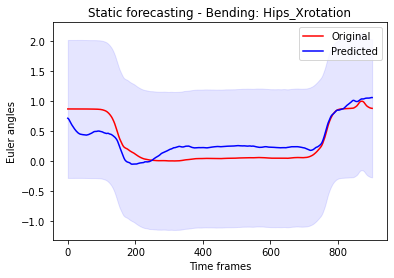

In [22]:
%matplotlib inline 

alpha = 0.05 # Represents the 95% of the distribution of the joint angle sequence

pred = predStatic_B
y = OrigValues_B

ci = (1-(alpha/2)) * np.std(y)/np.mean(y) # Calculate interval

# Plot the predictions, original values, and confidence intervals in the same plot:
plt.figure(1)
plt.plot(y, 'r',label='Original')
plt.plot(pred, 'b',label='Predicted')
plt.fill_between(np.arange(len(y)), (y-ci), (y+ci), color='b', alpha=.1)
plt.legend()
plt.xlabel("Time frames")
plt.ylabel("Euler angles")
plt.title("Static forecasting - Bending: " + ang_B) 
plt.show()

**3.3** We will evaluate the predictions with standard metrics. 
The quantitative measurement of the forecasting performance is usually done with the following metrics (Close to zero the better):
* Mean squared error ($MSE$): 

    $MSE = \sum_{t=1}^{N}(x_t-y_t)^2$


* Mean absolute error ($MAE$): 

    $MAE = \frac{1}{n}\sum_{t=1}^{n}\left |x_t-y_t\right|$


* Theil inequality coefficient ($U_{1}$): 

    $U_1 =\frac{\sqrt{\frac{1}{T}\sum_{t=1}^{T}(x_t-y_t)^{2}}}{\sqrt{\frac{1}{T}\sum_{t=1}^{T}x_t^{2}} + \sqrt{\frac{1}{T}\sum_{t=1}^{T}y^{2}}}$


In [23]:
def MSE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.square(y_true - y_pred))

def MAE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def U_Theil(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    er = y_true - y_pred
    u1 = np.sqrt(np.mean(np.square(er)))/(np.sqrt(np.mean(np.square(y_pred)))+np.sqrt(np.mean(np.square(y_true))))
    return u1

In [24]:
mse = MSE(y, pred)
mae = MAE(y, pred)
u1 = U_Theil(y, pred)

print('MSE: '+str(mse)+' *** MAE: '+str(mae)+' *** U1: '+str(u1))

MSE: 0.04212299965450495 *** MAE: 0.17812058475353665 *** U1: 0.21984552561948814


**3.4** In the next cell we forecast now the **test motion**  of **glassblowing**:

In [25]:
nob = data_TestG.shape[0] # Number of observations

endoData = data_TestG[:,indEnd_G] # Grab endogenous data
exogData = data_TestG[:,indExo_G] # Grab exogenous data

predStatic=[] # List where predictions will be appended
OrigValues=[] # List where the original values will be appended

model = model_G

for i in range(2,nob-1): # For loop for the one-sample prediction of the full motion
    forecast = model.apply(endoData[i-2:i], exog = exogData[i-2:i,:])           
    pred = forecast.get_prediction()
    pred_mean = pred.predicted_mean # Obtain the predicted value
    
    predStatic.append(pred_mean[0]) # Append prediction to the list
    OrigValues.append(endoData[i+1]) # Append original value to the list

predStatic_G = np.asarray(predStatic) 
OrigValues_G = np.asarray(OrigValues)

**3.5** Next, we plot the prediction and original values for comparison:

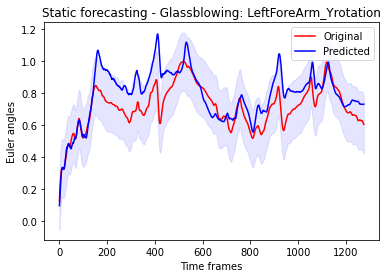

In [26]:
%matplotlib inline 
alpha = 0.05 # Represents the 95% of the distribution of the joint angle sequence

pred = predStatic_G
y = OrigValues_G
ci = (1-(alpha/2)) * np.std(y)/np.mean(y) # Calculate interval

# Plot the predictions, original values, and confidence intervals in the same plot:
plt.figure(1)
plt.plot(y, 'r',label='Original')
plt.plot(pred, 'b',label='Predicted')
plt.fill_between(np.arange(len(y)), (y-ci), (y+ci), color='b', alpha=.1)
plt.legend()
plt.xlabel("Time frames")
plt.ylabel("Euler angles")
plt.title("Static forecasting - Glassblowing: " + ang_G)
plt.show()

**3.6** We evaluate the predictions with standard metrics:

In [27]:
mse = MSE(y, pred)
mae = MAE(y, pred)
u1 = U_Theil(y, pred)

print('MSE: '+str(mse)+' *** MAE: '+str(mae)+' *** U1: '+str(u1))

MSE: 0.013841432263363146 *** MAE: 0.09143979684451539 *** U1: 0.07643719086970586


## 4. Dynamic forecasting
For dynamic forecasting, we will use the one-sample prediction values of the endogenous data (lagged dependent variables) instead of the original values for future predictions.

**4.1** Next, we dynamically forecast the **test motion** observations of **bending forward**: 

* Initially, we grab the first two values of the endogenous data, and for the functionality of the SARIMAX model, we also grab the first two values of the exogenous data. Then, we indicate to the model the number of observations we want to forecast dynamically.

* The model predicts the whole joint angle sequence, which we save in a list and its original sequence in a second list for later comparison.

In [28]:
nob = data_TestB.shape[0] # Number of observations

endoData = data_TestB[:,indEnd_B] # Grab endogenous data
exogData = data_TestB[:,indExo_B] # Grab exogenous data

predDynamic_B=data_TestB[0:2,indEnd_B] # Grab first two values
OrigValues_B=data_TestB[0:2,indEnd_B]

model = model_B

for i in range(2,nob-1): # For loop for the one-sample prediction of the full motion
    forecast = model.apply(predDynamic_B[i-2:i], exog = exogData[i-2:i,:])  # Apply test data         
    pred = forecast.get_prediction()
    pred_mean = pred.predicted_mean # Obtain the predicted value
    
    predDynamic_B = np.append(predDynamic_B, pred_mean[0]) # Append prediction to the list
    OrigValues_B = np.append(OrigValues_B, endoData[i+1]) # Append original value to the list

**4.2** We plot the prediction and original values for comparison, and confidence intervals:

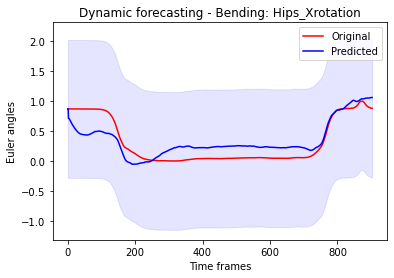

In [29]:
%matplotlib inline 

pred = predDynamic_B 
y = OrigValues_B

ci = (1-(alpha/2)) * np.std(y)/np.mean(y)

plt.figure(1)
plt.plot(y, 'r',label='Original')
plt.plot(pred, 'b',label='Predicted')
plt.fill_between(np.arange(len(y)), (y-ci), (y+ci), color='b', alpha=.1)
plt.legend()
plt.xlabel("Time frames")
plt.ylabel("Euler angles")
plt.title("Dynamic forecasting - Bending: " + ang_B)
plt.show()

**4.3** The quantitative measurement of the forecasting performance is done with the same metrics presented in *3.3*:

In [31]:
mse = MSE(y, pred)
mae = MAE(y, pred)
u1 = U_Theil(y, pred)

print('MSE: '+str(mse)+' *** MAE: '+str(mae)+' *** U1: '+str(u1))

MSE: 0.04202980717739321 *** MAE: 0.17772651266337394 *** U1: 0.21900138985377257


**4.4** Following, we dynamically forecast the **test motion** of **glassblowing**:

In [32]:
nob = data_TestG.shape[0] # Number of observations

endoData = data_TestG[:,indEnd_G] # Grab endogenous data
exogData = data_TestG[:,indExo_G] # Grab exogenous data

predDynamic_G = data_TestG[0:2,indEnd_G] # Grab first two values
OrigValues_G = data_TestG[0:2,indEnd_G]
model = model_G

for i in range(2,nob-1): # For loop for the one-sample prediction of the full motion
    forecast = model.apply(predDynamic_G[i-2:i], exog = exogData[i-2:i,:])  # Apply test data         
    pred = forecast.get_prediction()
    pred_mean = pred.predicted_mean # Obtain the predicted value
    
    predDynamic_G = np.append(predDynamic_G, pred_mean[0]) # Append prediction to the array
    OrigValues_G = np.append(OrigValues_G, endoData[i+1]) # Append original value to the array



**4.5** We plot the prediction and original values for comparison, and confidence intervals:

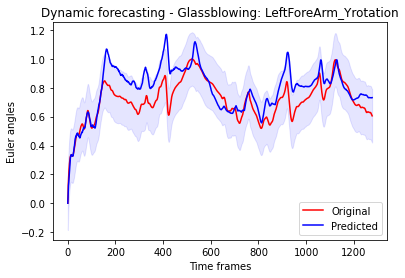

In [33]:
%matplotlib inline 

pred = predDynamic_G
y = OrigValues_G #From the second sample

ci = (1-(alpha/2)) * np.std(y)/np.mean(y)

plt.figure(1)
plt.plot(y, 'r',label='Original')
plt.plot(pred, 'b',label='Predicted')
plt.fill_between(np.arange(len(y)), (y-ci), (y+ci), color='b', alpha=.1)
plt.legend()
plt.xlabel("Time frames")
plt.ylabel("Euler angles")
plt.title("Dynamic forecasting - Glassblowing: " + ang_G)
plt.show()

**4.6** We evaluate the predictions with standard metrics:

In [34]:
mse = MSE(y, pred)
mae = MAE(y, pred)
u1 = U_Theil(y, pred)

print('MSE: '+str(mse)+' *** MAE: '+str(mae)+' *** U1: '+str(u1))

MSE: 0.0138197711800089 *** MAE: 0.0912966985708933 *** U1: 0.07643708876019131


## BONUS: Simpler way for dynamic forecasting

In [82]:
# EXAMPLE WITH GLASSBLOWING MOTION:

nobTest = data_TestG.shape[0] # Number of observations

endoData = data_TestG[0:2,indEnd_G] # Grab first two values
exogData = data_TestG[0:2,indExo_G]

model = model_G.append(endoData, exog = exogData) #Add first two real values in the model's data

exogData2 = data_TestG[2:,indExo_G] # Grab rest of exogenous data

# Dynamic forecasting by indicating number of samples to forecast and its exogenous data:
predict_dy = model.get_forecast(steps= nobTest-2, exog=exogData2) 

predDynamic_G = predict_dy.predicted_mean

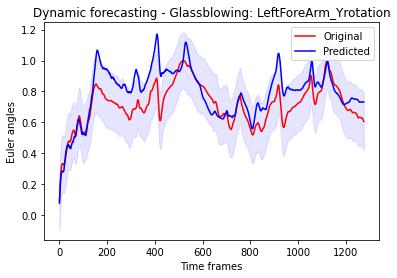

In [83]:
# PLOT: 
%matplotlib inline 

pred = predDynamic_G
y = OrigValues_G[2:] #From the second sample

ci = (1-(alpha/2)) * np.std(y)/np.mean(y)

plt.figure(1)
plt.plot(y, 'r',label='Original')
plt.plot(pred, 'b',label='Predicted')
plt.fill_between(np.arange(len(y)), (y-ci), (y+ci), color='b', alpha=.1)
plt.legend()
plt.xlabel("Time frames")
plt.ylabel("Euler angles")
plt.title("Dynamic forecasting - Glassblowing: " + ang_G)
plt.show()